In [1]:
# Image pre-processing params
low_info = 0.2
bright_strength = 1.5
med_size = 5
sharp_strength = 2
win_size = 64
win_stride = 16

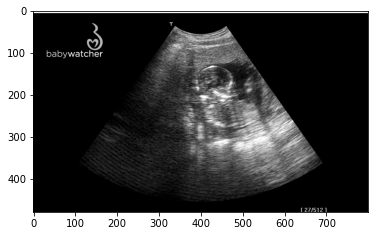

In [2]:
import os, random
import cv2
import matplotlib.pyplot as plt

os.chdir('..')
os.chdir('../resources')
pwd = os.getcwd()

img_name = random.choice(os.listdir(pwd+'/images/1'))

original_image = cv2.imread(pwd+'/images/1/'+img_name, 0)
plt.imshow(original_image, cmap='gray')

# I. Apply Image pre-processing/filtering
### 1. Crop outside part of image

Original shape (480, 800) 
New Shape (416, 520)


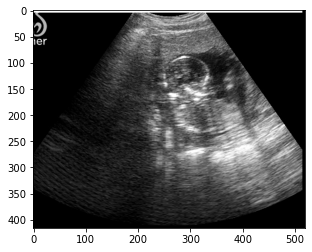

In [3]:
import numpy as np
import pandas as pd

# to_crop = 2D grayscale image array
# threshold = [0-1] maximum 0s in row/col
# Removes parts of to_crop that have less than *threshold* information and pads array to shape divisible 8
def crop_low_info(to_crop, threshold):
    cropped = pd.DataFrame(to_crop)
    cropped = cropped.replace([0],np.nan)
    cropped = cropped.dropna(thresh=cropped.shape[0]*threshold,how='all',axis=1)
    cropped = cropped.dropna(thresh=cropped.shape[0]*threshold,how='all',axis=0)
    cropped = cropped.replace(np.nan,0).astype(np.uint8)
    cropped = np.pad(cropped, [(0, 8-cropped.shape[0]%8), (0, 8-cropped.shape[1]%8)], mode='constant', constant_values=0)
    return cropped


cropped_image = crop_low_info(original_image, 0.2)
print('Original shape {} \nNew Shape {}'.format(original_image.shape,cropped_image.shape))
plt.imshow(cropped_image, cmap='gray')

### 2. Apply filters

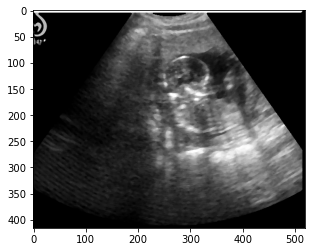

In [4]:
from PIL import Image, ImageEnhance

# Adjust brightness
def brighten(to_brighten, amount):
    to_brighten = Image.fromarray(to_brighten)
    converter = ImageEnhance.Brightness(to_brighten)
    return np.asarray(converter.enhance(amount))

def sharpen(to_sharpen, amount):
    to_sharpen = Image.fromarray(to_sharpen)
    converter = ImageEnhance.Sharpness(to_sharpen)
    return np.asarray(converter.enhance(amount))
  
def blur(to_blur, size):
    return cv2.medianBlur(to_blur, size)

def apply_filters(image, brighten_strength, median_size, sharpen_strength, steps=False):
    bright = brighten(image, brighten_strength)
    median = blur(bright, median_size)
    sharp = sharpen(median, sharpen_strength)
    return (bright, median, sharp) if steps else sharp


processed_image = apply_filters(cropped_image,1,5,2, steps=False)
plt.imshow(processed_image, cmap='gray')

### 3. Whole pre-processing pipeline

In [5]:
# Already filled in with magic variables. None of these are set
def process_image(image):
    cropped = crop_low_info(image, low_info)
    filtered = apply_filters(cropped, bright_strength, med_size, sharp_strength, steps=False)
    return filtered

processed_image = process_image(original_image)

# II. Feature recognition pipeline

### 1. Slide different size window over image
Make all sliding windows square. Including for long features (e.g spine, legs, arms)

### TODO vectorize for speed (not a priority)

In [6]:
%%time
# Input image and window_size
# Returns list of window_size sub-section of whole image
def get_window_coords(x, y, size):
    return np.ix_(np.arange(x, x+size),np.arange(y, y+size))

def get_windows(image, window_size, win_stride = 1):
    # x, y and size are int
    # window is list/np array
    windows = []
    x_arr = []
    y_arr = []
    for x in range(0, image.shape[0]-window_size+1, win_stride):
        for y in range(0, image.shape[1]-window_size+1, win_stride):
            window = image[get_window_coords(x, y, window_size)]
            x_arr.append(x)
            y_arr.append(y)
            windows.append(window)
    windows = pd.DataFrame({'x': x_arr, 'y': y_arr, 'window_size': [window_size]*len(y_arr), 'window':windows})
    return windows


windows = get_windows(processed_image, 64, win_stride = 16)
print('{} windows were made'.format(len(windows)))

667 windows were made
Wall time: 13 ms


In [7]:
def show_video(frames, title=None):
    i = 0
    t = 'frame'
    while(True):
        gray = frames[i]
        i = (i+1)%len(frames)
        if(title is not None):
            t = title[i]
        cv2.imshow(t,gray)
        k = cv2.waitKey(2000)
        if k == 27:         # If escape was pressed exit
            cv2.destroyAllWindows()
            break

#show_video(windows)

### 2. Apply HOG to all windows

- For each feature:  
    - For each window: 
        - Resize to (128, 128)
        - Apply HOG
        - Save HOG

### TODO vectorize for speed (not a priority)

In [8]:
%%time
from skimage.feature import hog

def compute_hog(window):
    w = cv2.resize(window, (128, 128))
    fd = hog(w, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(4, 4),block_norm= 'L2')
    return np.reshape(fd, (1, -1))

windows['hog'] = windows['window'].apply(compute_hog)
print('{} HOG features per window'.format(windows.loc[0]['hog'].shape))

(1, 3200) HOG features per window
Wall time: 1.47 s


### 4. Train Classifiers

Small dataset with high dimensionality (HOG -> 32000) so we need a linear and strongly regularized model such as Linear SVM. 

We'll also have one SVM per feature that way we can have a more accurate check (eg: Is this a head or not? Is this a spine or not? etc... for each feature)

Read images of known features (including none, for simplicity when training)

In [9]:
%%time
features = []
pixels = []
img_names = []
feature_names = ['head', 'spine']#, 'leg', 'arm', 'hand', 'foot']
for feature in feature_names+ ['none']:
    file_names = os.listdir(pwd+'/features/'+feature)
    img_names = img_names + file_names
    for file in file_names:
        features.append(feature)
        pixels.append(cv2.imread(pwd+'/features/'+feature+'/'+file, 0))

feature_images = pd.DataFrame({'image_name': img_names,'class' : features, 'image_pixels': pixels})

print('Total features: ', feature_images.shape[0])
print(feature_images.value_counts('class'))
feature_images.head(5)

Total features:  586
class
head     357
none     167
spine     62
dtype: int64
Wall time: 346 ms


,image_name,class,image_pixels
0,19150_2021-01-24_10.31_103052326.png,head,"[[61, 60, 54, 56, 55, 56, 62, 67, 72, 77, 84, ..."
1,19158_2021-01-09_19.37_193140441.png,head,"[[58, 49, 48, 51, 57, 64, 65, 65, 64, 61, 54, ..."
2,19158_2021-01-10_19.16_19114035.png,head,"[[91, 95, 91, 87, 88, 95, 103, 101, 99, 93, 93..."
3,19162_2021-01-08_13.46_13434478.png,head,"[[119, 124, 121, 114, 108, 102, 99, 100, 106, ..."
4,19162_2021-01-08_14.14_141028517.png,head,"[[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, ..."


Feature stats (useless af btw):

In [10]:
width = []
height = []
avg = []
for idx, row in feature_images.iterrows():
    width.append(row['image_pixels'].shape[0])
    height.append(row['image_pixels'].shape[1])
    avg.append(row['image_pixels'].mean())

stats = pd.DataFrame({'width':width, 'height':height, 'mean':avg})
print(stats.describe())

            width      height        mean
count  586.000000  586.000000  586.000000
mean   130.566553  153.837884   85.225469
std     46.021844   45.608546   15.975644
min     19.000000   48.000000   30.000000
25%    102.250000  121.000000   76.869891
50%    126.000000  148.000000   86.382738
75%    156.750000  182.000000   93.324300
max    270.000000  305.000000  141.022472


Get images ready for HOG:
1. Filter
2. Resize to (128, 128)

In [11]:
%%time
def resize(x):
    return cv2.resize(x,(128, 128))

feature_images['filtered_pixels'] = feature_images['image_pixels'].apply(process_image)
feature_images['resized_pixels'] = feature_images['filtered_pixels'].apply(resize)
feature_images.head(5)

Wall time: 1.53 s


,image_name,class,image_pixels,filtered_pixels,resized_pixels
0,19150_2021-01-24_10.31_103052326.png,head,"[[61, 60, 54, 56, 55, 56, 62, 67, 72, 77, 84, ...","[[84, 84, 82, 82, 82, 84, 84, 93, 100, 108, 11...","[[84, 83, 82, 82, 83, 84, 94, 103, 113, 124, 1..."
1,19158_2021-01-09_19.37_193140441.png,head,"[[58, 49, 48, 51, 57, 64, 65, 65, 64, 61, 54, ...","[[87, 87, 85, 91, 97, 97, 96, 96, 91, 85, 90, ...","[[87, 87, 85, 89, 95, 97, 96, 96, 93, 88, 87, ..."
2,19158_2021-01-10_19.16_19114035.png,head,"[[91, 95, 91, 87, 88, 95, 103, 101, 99, 93, 93...","[[136, 136, 136, 138, 138, 142, 144, 142, 142,...","[[136, 136, 137, 138, 141, 144, 142, 141, 139,..."
3,19162_2021-01-08_13.46_13434478.png,head,"[[119, 124, 121, 114, 108, 102, 99, 100, 106, ...","[[181, 180, 178, 171, 165, 159, 157, 157, 159,...","[[181, 180, 178, 172, 166, 161, 158, 157, 158,..."
4,19162_2021-01-08_14.14_141028517.png,head,"[[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, ...","[[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, ...","[[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, ..."


Compute HOG features

In [12]:
%%time
feature_images['hog'] = feature_images['resized_pixels'].apply(compute_hog)
feature_images.head(5)

Wall time: 945 ms


,image_name,class,image_pixels,filtered_pixels,resized_pixels,hog
0,19150_2021-01-24_10.31_103052326.png,head,"[[61, 60, 54, 56, 55, 56, 62, 67, 72, 77, 84, ...","[[84, 84, 82, 82, 82, 84, 84, 93, 100, 108, 11...","[[84, 83, 82, 82, 83, 84, 94, 103, 113, 124, 1...","[[0.05425872531085668, 0.056609912680651325, 0..."
1,19158_2021-01-09_19.37_193140441.png,head,"[[58, 49, 48, 51, 57, 64, 65, 65, 64, 61, 54, ...","[[87, 87, 85, 91, 97, 97, 96, 96, 91, 85, 90, ...","[[87, 87, 85, 89, 95, 97, 96, 96, 93, 88, 87, ...","[[0.04175902912607476, 0.04738230850899233, 0...."
2,19158_2021-01-10_19.16_19114035.png,head,"[[91, 95, 91, 87, 88, 95, 103, 101, 99, 93, 93...","[[136, 136, 136, 138, 138, 142, 144, 142, 142,...","[[136, 136, 137, 138, 141, 144, 142, 141, 139,...","[[0.029550289486343133, 0.009908633301573417, ..."
3,19162_2021-01-08_13.46_13434478.png,head,"[[119, 124, 121, 114, 108, 102, 99, 100, 106, ...","[[181, 180, 178, 171, 165, 159, 157, 157, 159,...","[[181, 180, 178, 172, 166, 161, 158, 157, 158,...","[[0.04777874987396255, 0.02467615803389799, 0...."
4,19162_2021-01-08_14.14_141028517.png,head,"[[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, ...","[[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, ...","[[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Separate into test and train data

Train Linear SVMs for each feature

In [13]:
%%time

from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

feature_svm = []
accuracy = []
classification_rep = []
for feature in feature_names:
    df = feature_images[feature_images['class'].isin([feature, 'none'])]
    
    labels =  np.array(df['class']).reshape(len(df['class']),1)
    hog_features = np.stack(df['hog'], axis=1)[0]
    data = np.hstack((hog_features,labels))

    np.random.shuffle(data)
    percentage = 80
    partition = int(len(data)*percentage/100)

    x_train, x_test = data[:partition,:-1],  data[partition:,:-1]
    y_train, y_test = data[:partition,-1:].ravel() , data[partition:,-1:].ravel()

    clf = svm.SVC(probability=True)
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    feature_svm.append(clf)
    accuracy.append(accuracy_score(y_test, y_pred))
    classification_rep.append(classification_report(y_test, y_pred))

results = pd.DataFrame({'feature': feature_names, 'svm': feature_svm, 'accuracy': accuracy, 'classification report': classification_rep})

Wall time: 1.2 s


Print results

In [14]:
for idx,row in results.iterrows():
    print(row['feature'])
    print('accuracy: '+str(row['accuracy']))
    print(row['classification report'])
    print('\n')

head
accuracy: 0.9142857142857143
              precision    recall  f1-score   support

        head       0.88      1.00      0.94        69
        none       1.00      0.75      0.86        36

    accuracy                           0.91       105
   macro avg       0.94      0.88      0.90       105
weighted avg       0.92      0.91      0.91       105



spine
accuracy: 0.782608695652174
              precision    recall  f1-score   support

        none       0.79      0.97      0.87        34
       spine       0.75      0.25      0.38        12

    accuracy                           0.78        46
   macro avg       0.77      0.61      0.62        46
weighted avg       0.78      0.78      0.74        46





### 3. Run all HOG features through each pre-trained classfication model
Each feature will have an separate SVM so:
- For each HOG features
    - For each SVM
        - Get match strength of HOG to feature

Filter out matches below threshold and sort by match strength. Highest wins

Low amount of data and high number of features, so we need a classification model that has bias/low variance such as Linear SVM.

https://www.kdnuggets.com/2020/05/guide-choose-right-machine-learning-algorithm.html

In [26]:
pred_threshold = 0.9
none_threshold = 0.6

def predict(hog_f):
    predictions = pd.DataFrame()
    for idx,row in results.iterrows():
        pred = row['svm'].predict_proba(np.reshape(hog_f, (1, -1)))[0]
        pred = dict(zip(row['svm'].classes_, pred))
        pred = pd.DataFrame(pred.items(), columns= ['class', 'prediction'])
        predictions = pd.concat([predictions, pred])
    predictions = predictions.sort_values(by='prediction', ascending=False).reset_index()
    if predictions.iloc[0]['prediction'] < pred_threshold or predictions[predictions['class']=='none']['prediction'].max()> none_threshold:
        return 'none', 1
    return predictions.iloc[0]['class'], predictions.iloc[0]['prediction']

def predict_df(windows_df):
    w = windows['hog'].apply(predict)
    i = 0
    def add_to_col(t):
        return t[i]
    windows_df['class'] = w.apply(add_to_col)
    i = 1
    windows_df['prediction'] = w.apply(add_to_col)
    return windows_df

# Full pipeline

In [27]:
%%time

low_info = 0.2
bright_strength = 1.5
med_size = 5
sharp_strength = 2
win_size = 64
win_stride = 16
pred_threshold = 0.9
none_threshold = 0.6

def process_image(image):
    cropped = crop_low_info(image, low_info)
    filtered = apply_filters(cropped, bright_strength, med_size, sharp_strength, steps=False)
    return filtered

def hog_pipeline(image):
    processed = process_image(image)
    windows = get_windows(processed, win_size, win_stride)
    windows['hog'] = windows['window'].apply(compute_hog)
    return windows

Wall time: 0 ns


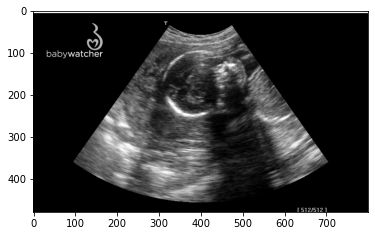

In [33]:
img_name = random.choice(os.listdir(pwd+'/images/1'))
original_image = cv2.imread(pwd+'/images/1/'+img_name, 0)
plt.imshow(original_image, cmap='gray')

In [34]:
windows = hog_pipeline(original_image)
windows = predict_df(windows)
found = windows[windows['class']!='none'].reset_index(drop=True)
found

,x,y,window_size,window,hog,class,prediction


In [35]:
original_image = cv2.cvtColor(original_image,cv2.COLOR_GRAY2RGB)
for idx, row in found.iterrows():
    original_image = cv2.rectangle(original_image, (row['x'], row['y']), (row['x']+row['window_size'], row['y']+row['window_size']), (255,0,0), 2)
    original_image = cv2.putText(original_image,  row['class'], (row['x'],  row['y']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

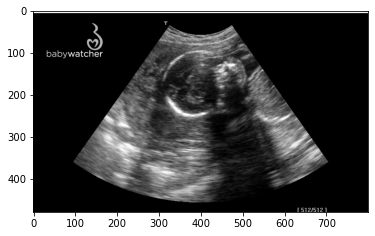

In [36]:
plt.imshow(original_image)